# CIMP Cluster detection

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict, Counter
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

from core.data_access.matrix_factory import MatrixFactory as mf

/Users/billiegould/Desktop/research/env/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/billiegould/Desktop/research/configs/keys.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  keys = yaml.load(download_blob(BUCKET, 'keys.yaml', as_bytes=True))


In [2]:
# import CIMP probes (Hinoue et al 2012, table S4) (from HM27K array)

# probes defining CIMP vs non-CIMP
df_cimp_HL_probes = pd.read_csv(open("./Hinoue_Supplemental_Table4/CIMP-H and CIMP-L-Table 1.csv", "r"))
print(len(df_cimp_HL_probes))

#probes defining CIMP-H vs CIMP-L
df_cimp_H_probes = pd.read_csv(open("./Hinoue_Supplemental_Table4/CIMP-H-Table 1.csv", "r"))
print(len(df_cimp_H_probes))

#probes defining non-cimp CRC 
df_non_cimp_CRC_probes = pd.read_csv(open("./Hinoue_Supplemental_Table4/Non-CIMP cancer specific-Table 1.csv"))
print(len(df_non_cimp_CRC_probes))

cimp_probes = list(df_cimp_HL_probes["Probe ID"]) + list(df_cimp_H_probes["Probe ID"]) + list(df_non_cimp_CRC_probes["Probe ID"])
#print(cimp_probes)

assert np.sum( [ cimp_probes.count(x) for x in cimp_probes]) == len(cimp_probes) # no duplicates
print(len(cimp_probes))

73
415
547
1035


# CIMP cluster detection using TCGA methyl chip tissue data

In [3]:
# Import TCGA methyl chip data
df_tcga = pickle.load(open("../TCGA_COAD_READ/df_coad_read_raw_beta_vals.pkl", "rb"))

df_tcga.head()

,TCGA-CI-6620-01A-11D-1828-05,TCGA-EI-6882-01A-11D-1926-05,TCGA-CI-6622-01A-11D-1828-05,TCGA-AG-3731-11A-01D-1734-05,TCGA-EI-6509-01A-11D-1734-05,TCGA-DY-A1H8-01A-21D-A153-05,TCGA-DC-5869-01A-01D-1658-05,TCGA-AF-2687-01A-02D-1734-05,TCGA-AF-4110-01A-02D-1734-05,TCGA-CI-6624-01C-11D-1828-05,...,TCGA-NH-A50T-01A-11D-A28O-05,TCGA-AZ-4308-01A-01D-1407-05,TCGA-D5-6535-01A-11D-1721-05,TCGA-T9-A92H-01A-11D-A36Y-05,TCGA-G4-6322-01A-11D-1721-05,TCGA-G4-6303-01A-11D-1772-05,TCGA-AZ-5407-01A-01D-1721-05,TCGA-A6-2677-01A-01D-A27A-05,TCGA-F4-6570-01A-11D-1772-05,TCGA-NH-A5IV-01A-42D-A36Y-05
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.163845,0.127087,0.125635,0.280018,0.066121,0.133101,0.161283,0.300397,0.156672,0.215786,...,0.127350,0.110104,0.204686,0.059192,0.233573,0.137660,0.147555,0.236415,0.316811,0.099436
cg00000108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000165,0.444613,0.115232,0.505875,0.209528,0.630331,0.384846,0.578823,0.190392,0.176845,0.207360,...,0.741897,0.131011,0.285173,0.653738,0.393665,0.222852,0.565006,0.480643,0.557870,0.085557
cg00000236,0.889824,0.909430,0.911645,0.865826,0.860653,0.925704,0.922209,0.865193,0.899154,0.913182,...,0.918606,0.910091,0.900324,0.894857,0.896283,0.905304,0.893371,0.927632,0.935442,0.840959


In [4]:
# get tcga probe annotations
test_data = pd.read_csv("../TCGA_COAD_READ/jhu-usc.edu_LUAD.HumanMethylation450.1.lvl-3.TCGA-44-2655-11A-01D-1551-05.gdc_hg38.txt",
                       sep="\t")
#df_probe_meta = test_data.drop("Beta_value", axis=1)
df_probe_meta_450 = test_data.set_index("Composite Element REF")
df_probe_meta_450 = df_probe_meta_450.loc[:,["Chromosome","Start","End"]]
print(df_probe_meta_450.shape)

#probe info for the HM27 chip
hm27_data = pd.read_csv("../CIMP/jhu-usc.edu_COAD.HumanMethylation27.1.lvl-3.TCGA-AA-3534-11A-01D-1552-05.gdc_hg38.txt", sep="\t")
hm27_data = hm27_data.set_index("Composite Element REF")
df_probe_meta_27 = hm27_data.loc[:,["Chromosome","Start","End"]]
print(df_probe_meta_27.shape)

df_probe_meta = pd.concat([df_probe_meta_450, df_probe_meta_27], axis=0) #513155 >>
print(df_probe_meta.shape)
df_probe_meta = df_probe_meta.loc[~df_probe_meta.index.duplicated(keep='first')]
print(df_probe_meta.shape)
df_probe_meta.head()

# CIMP probe annotations

#print(df_probe_meta.head())
probes = [prb in cimp_probes for prb in df_probe_meta.index]
df_probe_meta_cimp = df_probe_meta[probes]  # 2 of these probes have chr="*", ambig mapping

print(df_probe_meta_cimp.shape)

(485577, 3)
(27578, 3)
(513155, 3)
(487177, 3)
(1035, 3)


In [5]:
# Load TCGA sample metadata
tcga_sample_metadata = pickle.load(open("../TCGA_COAD_READ/coad_read_sample_metadata.pkl", "rb"))
labels = [(d["sample_type"]+"_"+d["study"]) for d in tcga_sample_metadata]
print(len(tcga_sample_metadata))
print(tcga_sample_metadata[0:4])


404
[{'identifier': 'TCGA-CI-6620-01A-11D-1828-05', 'tss': 'CI', 'participant': '6620', 'sample_type': 'CRC', 'plate': '1828', 'center': '05', 'study': 'READ'}
 {'identifier': 'TCGA-EI-6882-01A-11D-1926-05', 'tss': 'EI', 'participant': '6882', 'sample_type': 'CRC', 'plate': '1926', 'center': '05', 'study': 'READ'}
 {'identifier': 'TCGA-CI-6622-01A-11D-1828-05', 'tss': 'CI', 'participant': '6622', 'sample_type': 'CRC', 'plate': '1828', 'center': '05', 'study': 'READ'}
 {'identifier': 'TCGA-AG-3731-11A-01D-1734-05', 'tss': 'AG', 'participant': '3731', 'sample_type': 'Normal', 'plate': '1734', 'center': '05', 'study': 'READ'}]


In [6]:
# filter data for cimp probes (from HM27K array)
print(df_tcga.shape)

probes = [prb in cimp_probes for prb in df_tcga.index]
df_tcga_cimp = df_tcga[probes]

# 1002/1035 CIMP/CRC defining probes are in the tcga 450K data set. 
print(df_tcga_cimp.shape)


(465923, 404)
(1002, 404)


Composite Element REF
cg00015770    0
cg00024396    0
cg00059225    0
cg00107187    0
cg00240432    0
             ..
cg27554782    0
cg27560864    0
cg27560922    0
cg27603796    0
cg27634151    0
Length: 1002, dtype: int64
(404, 960)
0


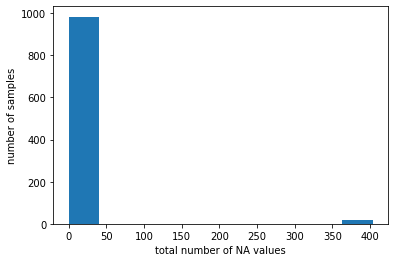

In [7]:
# Filter out probes with a high rate of NA (run once only)
na_sums = df_tcga_cimp.apply(lambda x: np.sum(x.isnull()), axis=1)
print(na_sums)
plt.hist(na_sums)
plt.xlabel("total number of NA values")
plt.ylabel("number of samples")

for prb in df_tcga_cimp.index:
    if any(df_tcga_cimp.loc[prb].isnull()):
        df_tcga_cimp = df_tcga_cimp.drop(prb)

df_tcga_cimp = df_tcga_cimp.T
print(df_tcga_cimp.shape)
print(df_tcga_cimp.isnull().sum().sum())

In [29]:
# perform hierarchical clustering
"""
def test_opt_num_clust(mat, labels, fig_pfx):
    
    cols = sns.color_palette("Paired")
    d_row_colors = {"Normal_COAD": cols[0], "CRC_COAD":cols[4], "Normal_READ":cols[1], "CRC_READ":cols[5]}
    row_colors = [d_row_colors[lab] for lab in labels]

    #color rows by cluster id
    cols = sns.color_palette("Set2")
    clust = AgglomerativeClustering(n_clusters=2, linkage="ward") #must use default euclidean dist metric
    clust.fit(mat)
    clust_colors = [cols[c] for c in clust.labels_]
    
    cg = sns.clustermap(mat, figsize=(20,50), 
                        row_colors=[row_colors, clust_colors],
                        xticklabels=[], 
                        yticklabels=[], 
                        method="ward")
    cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram
    plt.savefig(f"./{fig_pfx}_heatmap.png")

    k_vals = [2,3,4,5,6,7,8]
    scores = []
    for k in k_vals:
        clust = AgglomerativeClustering(n_clusters=k, linkage="ward")
        clust.fit(mat)
        #score = metrics.calinski_harabasz_score(mat, clust.labels_)
        score = np.mean(metrics.silhouette_score(mat, clust.labels_))
        scores.append(score)
        #print(f"groups {k} : {round(score, 3)}")
    
    plt.figure()
    plt.scatter(k_vals, scores, lw=2)
    plt.plot(k_vals, scores, lw=2)
    plt.xlabel("number of clusters")
    plt.ylabel("clustering score")
    plt.savefig(f"./{fig_pfx}_scores.png")
"""

In [10]:
# K-means clustering 

def test_opt_num_clust_kmeans(mat, labels, fig_pfx=None):
    k_vals = [1,2,3,4,5,6,7,8]
    scores = []
    for k in k_vals:
        clust = KMeans(n_clusters=k, random_state=0)
        clust.fit(mat)
        #score = np.mean(metrics.silhouette_score(mat, clust.labels_))
        score = clust.inertia_  # this is the total sums of within cluster summs of squares
        scores.append(score)
        #print(f"groups {k} : {round(score, 3)}")
    plt.figure()
    plt.scatter(k_vals, scores, lw=2)
    plt.plot(k_vals, scores, lw=2)
    plt.xlim((0,8.5))
    plt.hlines(scores[2],linestyles='dashed', xmin=0, xmax=9)
    plt.title("total within-cluster variation")
    plt.xlabel("number of clusters")
    plt.ylabel("total sums of squares")
    if fig_pfx:
        plt.savefig(f"./{fig_pfx}_scores.png")
    
    # make heatmap labeled by clusters at k=3
    plt.figure(figsize=(20,20))
    cols = sns.color_palette("Paired")
    d_row_colors = {"Normal_COAD": cols[0], "CRC_COAD":cols[4], "Normal_READ":cols[1], "CRC_READ":cols[5]}
    row_colors = pd.Series([d_row_colors[lab] for lab in labels], index=mat.index)

    #color rows by cluster id
    cols = sns.color_palette("Set2")
    clust = KMeans(n_clusters=3, random_state=0)
    clust.fit(mat)
    clust_colors = pd.Series([cols[c] for c in clust.labels_], index=mat.index)
    
    #sort rows by cluster membership
    clust_lab_sorted = pd.Series(clust.labels_, index=mat.index).sort_values()
    mat_row_sort = mat.reindex(clust_lab_sorted.index, axis=0)
    row_colors = row_colors.reindex(clust_lab_sorted.index)
    clust_colors = clust_colors.reindex(clust_lab_sorted.index)
    #sort cols from low to high
    #marker_sums = mat.apply(np.sum, axis=0)
    #mat_col_sort = mat_row_sort.reindex(marker_sums.sort_values().index, axis=1)

    #sns.heatmap(mat_col_sort, yticklabels=False, xticklabels=False)
    cg = sns.clustermap(mat_row_sort, figsize=(20,20), 
                        row_cluster=False, #col_cluster=False,
                        row_colors=[row_colors, clust_colors],
                        yticklabels=False, xticklabels=False)
    cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram
    if fig_pfx:
        plt.savefig(f"./{fig_pfx}_heatmap.png")

    return clust.labels_

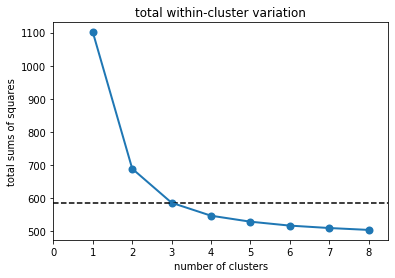

<Figure size 1440x1440 with 0 Axes>

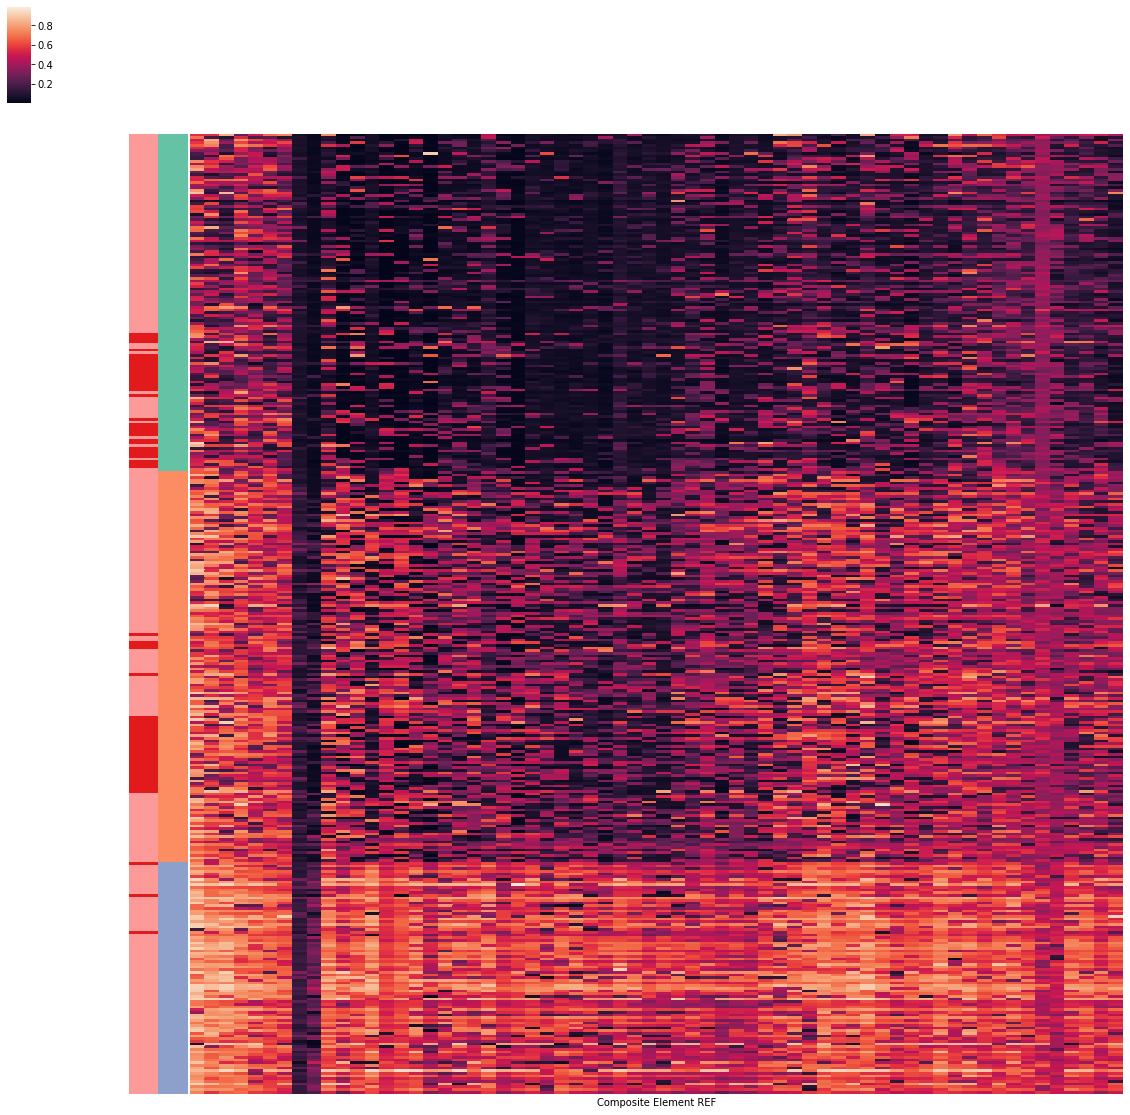

In [11]:
# test Kmeans clustering
labels = np.array([(d["sample_type"]+"_"+d["study"]) for d in tcga_sample_metadata])

#cluster using CIMP/non-CIMP probe set (n=547) on tcga crc's onlly
probes = [prb for prb in df_tcga_cimp.columns if prb in list(df_cimp_HL_probes["Probe ID"])]
df_tcga_cimp_sub = df_tcga_cimp.loc[:, probes]
samples = [d["sample_type"]=="CRC" for d in tcga_sample_metadata]
cluster_labels = test_opt_num_clust_kmeans(df_tcga_cimp_sub[samples], labels[samples], "tcga_crcs_cimpHL_kmeans")

In [252]:
print(df_tcga_cimp_sub[samples].shape)

(361, 64)


In [ ]:
# test hierarchical clustering

# perform clustering on tcga tissue methyl beta values for all samples
labels = np.array([(d["sample_type"]+"_"+d["study"]) for d in tcga_sample_metadata])

# cluster all tcga samples using all cimp markers
test_opt_num_clust(df_tcga_cimp, labels, "tcga_clust_cimp_probes")
# produces 3 good clusters, but there is not a split between CRC/normal
# when we split just CRC samples on these markers the optimal cluster number is 2

# cluster using CIMP/non-CIMP probe set (n=547) on tcga crc's onlly
#probes = [prb for prb in df_tcga_cimp.columns if prb in list(df_non_cimp_CRC_probes["Probe ID"])]
#df_tcga_cimp_sub = df_tcga_cimp.loc[:, probes]
#samples = [d["sample_type"]=="CRC" for d in tcga_sample_metadata]
#test_opt_num_clust(df_tcga_cimp_sub[samples], labels[samples], "tcga_clust_cimp_non_cimp_probes_crc_only")

# perform clustering on tcga tissue methyl beta values for CRC samples only
#samples = [d["sample_type"]=="CRC" for d in tcga_sample_metadata]
#labels = np.array([(d["sample_type"]+"_"+d["study"]) for d in tcga_sample_metadata])
#test_opt_num_clust(df_tcga_cimp[samples], labels[samples], "tcga_clust_cimp_probes_crc_only")

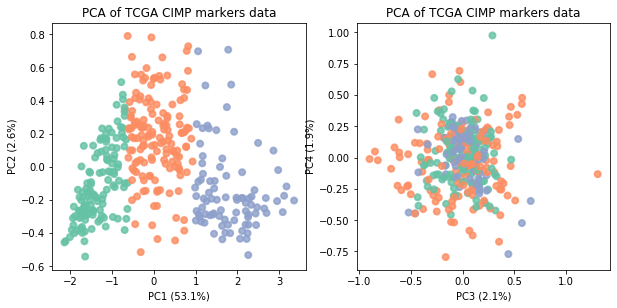

In [100]:
# PCA cluster plot of TCGA tissue data cimp marker data

samples = [d["sample_type"]=="CRC" for d in tcga_sample_metadata]
mat = df_tcga_cimp_sub[samples]
lbls = labels[samples]

pca = PCA(n_components=4)
pca = pca.fit(mat)
ratios_r = pca.transform(mat)

cols = sns.color_palette("Paired")
d_sample = {"Normal_COAD": cols[0], "CRC_COAD":cols[4], "Normal_READ":cols[1], "CRC_READ":cols[5]}
sample_colors = [d_sample[lab] for lab in lbls]

cols = sns.color_palette("Set2")
clust_colors = [cols[c] for c in cluster_labels]
    
plt.figure(figsize=(10,10))

## PCA Plot
plt.subplot(221)
plt.scatter(ratios_r[:, 0], ratios_r[:, 1], color=clust_colors, alpha=.8, lw=2)
plt.xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0]*100,1)}%)")
plt.ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1]*100,1)}%)")
plt.title('PCA of TCGA CIMP markers data')

plt.subplot(222)
plt.scatter(ratios_r[:, 2], ratios_r[:, 3], color=clust_colors, alpha=.8, lw=2)
plt.xlabel(f"PC3 ({round(pca.explained_variance_ratio_[2]*100,1)}%)")
plt.ylabel(f"PC4 ({round(pca.explained_variance_ratio_[3]*100,1)}%)")
plt.title('PCA of TCGA CIMP markers data')

plt.savefig("./tcga_cimp_pca.png")

# this is weird, I don't know what this means

# Clustering on cfDNA using regions in v1 panel containing Hinoue CIMP probes

In [163]:
# read in v1 panel bed
# the v1 panel is ~14K regions selected from lit and TCGA data. The DC1.5 TBS data was generated using this panel.
# panel development here: https://github.com/freenome/jsj_notebooks/blob/master/Featurization/Methylation/Create%20Methyl%20Panel%20V1.ipynb

v1_panel_dict = defaultdict(list)
v1_panel_bed = pd.read_csv(open("../methyl_panel_v1_target_twist.bed", "r"), sep="\t", header=None)
print(v1_panel_bed.head())
for i,row in v1_panel_bed.iterrows():
    v1_panel_dict[row[0]].append(list(row[1:4]))

print(v1_panel_dict.keys())

     0       1       2                            3  4    5    6         7   \
0  chr1  632108  632228  NM_001005277.1;OR4F16;54427  -  0.0  0.0  0.000000   
1  chr1  935143  935263     NM_152486.2;SAMD11;-9403  +  0.0  1.0  0.000000   
2  chr1  943939  944095      NM_015658.3;NOC2L;15205  -  0.0  0.0  0.903846   
3  chr1  963412  963532     NM_198317.2;KLHL17;-2826  +  0.0  0.0  0.841667   
4  chr1  970916  971158    NM_032129.2;PLEKHN1;-4420  +  1.0  1.0  0.000000   

    8         9   ...   18   19   20   21   22   23   24   25   26        27  
0  0.0  0.000000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.116667  
1  0.0  0.000000  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.133333  
2  0.0  0.000000  ...  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.000000  
3  0.0  0.000000  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
4  0.0  0.008264  ...  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.107438  

[5 rows x 28 columns]
dict_keys(['chr1', 'chr10', 

In [165]:
# CIMP probes in current panel
print(df_probe_meta_cimp.shape)
probes_in_v1_panel = []
regions_containing_cimp_prb = []
for i, row in df_probe_meta_cimp.iterrows():
    prb_loc = int(row.Start) - 1 # convert 1 based TCGA coords
    status = False
    if row.Chromosome != "*":
        for region in v1_panel_dict[row.Chromosome]:  # 0-based coords
            start, stop, genes = region
            if start <= prb_loc < stop:
                status = True
                #print(f"region: {start}, {stop} probe: {prb_loc}")
                regions_containing_cimp_prb.append([row.Chromosome] + region)
                break
    probes_in_v1_panel.append(status)

print(f"probes in v1 panel regions: {np.sum(probes_in_v1_panel)}")  #332 probes in v1 panel
print(regions_containing_cimp_prb[0:2])
print(len(regions_containing_cimp_prb)) # does not appear to contain duplicate regions
# first probe set did not include HM27 cimp probes not on HM450 = 332
# v2 probe set n=337

print(v1_panel_dict.keys())

(1035, 3)
probes in v1 panel regions: 337
[['chr4', 121380714, 121381277, 'NM_198179.2;QRFPR;0'], ['chr5', 151924586, 151925087, 'NM_000171.3;GLRA1;0']]
337
dict_keys(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', '*'])


In [166]:
# write panel regions containing CIMP probes as col metadata (332,1,2,) 
# (regions, thresholds, outputs, ) no sample dimension, there is only one threshold dimension
list_of_region_dicts = []
for region in regions_containing_cimp_prb:
    chrm, start, stop, genes = region
    list_of_region_dicts.append( {"chrm":chrm,
                                  "start":start,
                                  "stop":stop,
                                  "genes":genes})

thresh_dicts = [{"thresh": 3}]    
calc_dicts = [ {"descr":"total_frags"}, {"descr":"methyl_frags"}]

np.savez_compressed('./cimp_reg_hmfc_col_meta_v2.npz', np.array(list_of_region_dicts), np.array(thresh_dicts), np.array(calc_dicts))

# write bed file
df_cimp_regions = pd.DataFrame(list_of_region_dicts)
print(df_cimp_regions.head())

df_cimp_regions.to_csv("./v2_CIMP_v1_panel_regions.bed", sep="\t", header=None, index=None)

# put it here on the cloud: gsutil cp CIMP_v1_panel_regions.bed gs://reference-datafiles/beds/

    chrm      start       stop                     genes
0   chr4  121380714  121381277       NM_198179.2;QRFPR;0
1   chr5  151924586  151925087       NM_000171.3;GLRA1;0
2  chr14  104604510  104605011  NM_001286389.1;TMEM179;0
3   chr7   19117422   19117923      NM_000474.3;TWIST1;0
4   chr5    1883264    1883519     NM_016358.2;IRX4;-498


### calculate HMFC over these 337 regions using lowest calling threshold (3CPGs) in summarizer
ftio create feature
from the yaml file:
name: hyper_methylated_fragment_count_by_min_methyl_cpgs_per_CIMP_region
description: HMFC calculated at 3CPGs for 337 CIMP-associated regions that overlap the v1 panel
shape: (337,1,2,)
column_metadata: /Users/billiegould/Desktop/my_repo/startup/CIMP/cimp_reg_hmfc_col_meta_v2.npz

ftio update feature hyper_methylated_fragment_count_by_min_methyl_cpgs_per_CIMP_region 1 --shape_tuple "(332,1,2,)"

ftio update feature hyper_methylated_fragment_count_by_min_methyl_cpgs_per_CIMP_region 1 --numpy_dtype uint16

summarizer --func summarizer.methods.bamstat_runner.run \
    --region gs://reference-datafiles/beds/v2_CIMP_v1_panel_regions.bed \
    --statistic_kwargs "{'min_methyl_cpgs': [3]}" \
    --methyl_frag_statistic HMFC \
    --input_type training_class:colorectal_healthy_targetmethyl1_discovery1h,colorectal_cancer_targetmethyl1_discovery1h,colorectal_precancer_targetmethyl1_discovery1h,colorectal_benign_targetmethyl1_discovery1h,colorectal_healthy_targetmethyl1_discovery1h_panelofneg \
    --out_path hyper_methylated_fragment_count_by_min_methyl_cpgs_per_CIMP_region \
    --version 2 \
    --partitions preempt-standard16 \
    --c 14 \
    --mem 32000 \
    --download_bam_if_not_local

In [ ]:
# load cfDNA CIMP region data

# could also use this feature that has already been calculated by JSJ
# dc1_overfit_hmf_count_by_min_methyl_cpgs_per_region_all_clean_healthy_lt_1_perc_methyl
#
# import cfDNA data

classes = [ ('colorectal_healthy_targetmethyl1_discovery1h', 5),
              ('colorectal_cancer_targetmethyl1_discovery1h', 4),
              ('colorectal_precancer_targetmethyl1_discovery1h', 3),
              ('colorectal_benign_targetmethyl1_discovery1h', 2),
              ('colorectal_healthy_targetmethyl1_discovery1h_panelofneg', 1)]

mat = mf.create(classes=classes, 
                   feature='hyper_methylated_fragment_count_by_min_methyl_cpgs_per_CIMP_region_v2', 
                   skip_cache=True)

print(mat.x.shape)


class_to_name = {2:"Benign",
                   4:"Cancer",
                   5:"Healthy",
                   1:"PoN",
                   3:"Pre_Cancer"}

labels = [class_to_name[cls] for cls in mat.get_labels()]

In [172]:
#print(mat.x[0:10,0:4,])
print(mat.x.shape)
print(Counter(labels))
print(np.sum(np.isnan(mat.x)))

print(Counter(mat.get_labels()))

#print(mat.get_column_metadata())

(264, 337, 1, 2)
Counter({'Healthy': 89, 'Pre_Cancer': 61, 'Cancer': 49, 'Benign': 43, 'PoN': 22})
0
Counter({5: 89, 3: 61, 4: 49, 2: 43, 1: 22})


In [95]:
# check for missing sample data
from featureio import FeatureIO

with FeatureIO() as ftio:
    for cls, num in classes:
        dataset_list = ftio.get_datasets_for_training_class(cls) # a list of data set IDs
        print(f"class: {cls} samples: {len(dataset_list)}")
        # missing: 0 healthy, 1 cancer, 0 precancer, 0 benign, 0 PoN 
    ftio.close()

/Users/billiegould/Desktop/research/env/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


class: colorectal_healthy_targetmethyl1_discovery1h samples: 89
class: colorectal_cancer_targetmethyl1_discovery1h samples: 49
class: colorectal_precancer_targetmethyl1_discovery1h samples: 61
class: colorectal_benign_targetmethyl1_discovery1h samples: 43
class: colorectal_healthy_targetmethyl1_discovery1h_panelofneg samples: 22


In [ ]:
# Ichor tumor fraction data

#load tumor fraction info for cfDNA samples
classes = [ ('colorectal_healthy_cfdna2_discovery1h', 5),
              ('colorectal_cancer_cfdna2_discovery1h', 4),
              ('colorectal_precancer_cfdna2_discovery1h', 3),
              ('colorectal_benign_cfdna2_discovery1h', 2),
              ('colorectal_healthy_cfdna2_discovery1h_panelofneg', 1)]

mat_TF = mf.create(classes=classes, 
                   feature='ichor_tumor_fraction_mq60_v5', 
                   skip_cache=True)

print(mat_TF.x.shape)  # (554, 4)

mat_TF_col_meta = mat_TF.get_column_metadata()
print(mat_TF_col_meta)

mat_TF_sample_meta = mat_TF.get_metadata()

print(Counter(mat_TF.get_labels())) # missing 8 crc samples or so Counter({5: 383, 2: 48, 3: 44, 1: 42, 4: 37})

num_to = {2:"Benign",
                   4:"Cancer",
                   5:"Healthy",
                   1:"PoN",
                   3:"Pre_Cancer"}

In [16]:
# Ichor LOD for tumor fraction
healthies = [ lbl==5 for lbl in mat_TF.get_labels() ] 
#lod = max(mat_TF.x[healthies,0])
print(sorted(mat_TF.x[healthies,0])[-2:])

#print(mat_TF_sample_meta[0])
samples = [d["sample_id"] for d in mat_TF_sample_meta]
#tfs = [ 0 if tf<0.00694 else tf for tf in mat_TF.x[:,0]] #lod second highest score in healthies
#tf_dict = dict(zip(samples, tfs))
tf_dict = dict(zip(samples, mat_TF.x[:,0]))


crcs = [lbl==4 for lbl in mat_TF.get_labels()]
#plt.hist(np.array(tfs)[crcs])

[0.006939, 0.01052]


In [17]:
# subset by CRC and then remove regions where total fragments are low. run once only
num_to_lab = {2:"Benign",
            4:"Cancer",
            5:"Healthy",
            1:"PoN",
            3:"Pre_Cancer"}
labels = [ num_to_lab[lbl] for lbl in mat.get_labels()]
sample_metadata = mat.get_metadata()

samples = [lbl=="Cancer" for lbl in labels]

mat_crc = mat.x[samples,...]
print(mat_crc.shape)

cols_to_keep=[]
total_counts = pd.DataFrame(mat_crc[...,1].reshape((-1,337)))
for col in total_counts.columns:
    if any([val < 5 for val in total_counts.loc[:,col]]):
        cols_to_keep.append(False)
    else:
        cols_to_keep.append(True)

print(len(cols_to_keep))  # remove six regions

mat_crc_filt = mat_crc[:,cols_to_keep,...]
col_meta = mat.get_column_metadata()[cols_to_keep]
print(mat_crc_filt.shape)
print(len(col_meta))

(49, 337, 1, 2)
337
(49, 331, 1, 2)
331


0


(array([287.,  35.,   4.,   1.,   2.,   0.,   0.,   0.,   0.,   2.]),
 array([5.76101816e-04, 8.47363883e-02, 1.68896675e-01, 2.53056961e-01,
        3.37217248e-01, 4.21377534e-01, 5.05537821e-01, 5.89698108e-01,
        6.73858394e-01, 7.58018681e-01, 8.42178967e-01]),
 <a list of 10 Patch objects>)

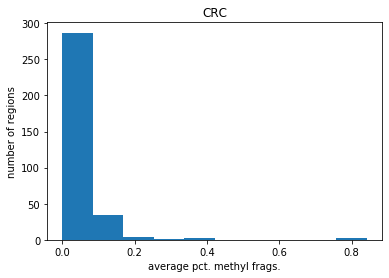

In [22]:
# histograms of average percent of fragments methylated per region for each class

region_pct_meth_crc = mat_crc_filt[...,0] / mat_crc_filt[...,1]
region_pct_meth_crc = pd.DataFrame(region_pct_meth_crc.reshape((-1,331)))
print(region_pct_meth_crc.isnull().sum().sum())

#for label in class_to_name.values():
#    samples = [ lbl==label for lbl in labels]
#    data = region_pct_meth[samples]
averages = region_pct_meth_crc.apply(np.mean, axis=0)
plt.figure()
plt.title(f"CRC")
plt.ylabel("number of regions")
plt.xlabel("average pct. methyl frags.")
plt.hist(averages)

In [ ]:
# calculate hmf rate (as proxy for tumor fraction) =hmfs per fragment across all regions
"""
hmfs = pd.DataFrame(mat_filt[...,0].reshape((-1,326)))
#print(hmfs.head())
hmfs_sample_sums = hmfs.apply(np.sum, axis=1)

frags = pd.DataFrame(mat_filt[...,1].reshape((-1,326)))
#print(frags.head())
tot_frag_sample_sums = frags.apply(np.sum, axis=1)

hmf_rates = hmfs_sample_sums/tot_frag_sample_sums

plt.figure()
plt.hist(hmf_rates)
"""

In [18]:
# subset regions containing cimpHL markers
df_probe_meta_cimpHL = df_probe_meta_cimp.loc[df_cimp_HL_probes["Probe ID"],:]
print(df_probe_meta_cimpHL.isnull().sum().sum()) # 73 probes
cimpHL_reg_bool = []
for reg_dict in col_meta: #list_of_region_dicts:
    keep=False
    for pbr, row in df_probe_meta_cimpHL.iterrows():
        #print(row.Start)
        if reg_dict["start"] <= (int(row.Start)-1) < reg_dict["stop"]:
            keep=True
    cimpHL_reg_bool.append(keep)
    
print(len(cimpHL_reg_bool))
print(np.sum(cimpHL_reg_bool)) # keeps 27/73 HL markers are present


0
331
27


In [75]:
# K-means clustering 2
def test_opt_num_clust_kmeans2(mat, labels, sample_metadata, fig_pfx=None):
    
    print(mat.shape)
    assert pd.DataFrame(mat).isnull().sum().sum() == 0, "NAs present"
    
    # subset input matrix
    #mat_sub = mat[samples,:]
    #print(mat_sub.shape)
    #labels_sub = labels[samples]
    #sample_metadata_sub = sample_metadata[samples]
    #assert pd.DataFrame(mat_sub).isnull().sum().sum() == 0, "NAs present"
    
    k_vals = [1,2,3,4,5,6,7,8]
    scores = []
    for k in k_vals:
        clust = KMeans(n_clusters=k, random_state=0)
        clust.fit(mat)
        #score = np.mean(metrics.silhouette_score(mat, clust.labels_))
        score = clust.inertia_  # this is the total sums of within cluster summs of squares
        scores.append(score)
        #print(f"groups {k} : {round(score, 3)}")
    plt.figure()
    plt.scatter(k_vals, scores, lw=2)
    plt.plot(k_vals, scores, lw=2)
    plt.xlim((0,8.5))
    plt.hlines(scores[1],linestyles='dashed', xmin=0, xmax=9)
    plt.title("total within-cluster variation")
    plt.xlabel("number of clusters")
    plt.ylabel("total sums of squares")
    if fig_pfx:
        plt.savefig(f"./{fig_pfx}_scores.png")
    
    # make heatmap labeled by clusters at k=3
    cols = sns.color_palette("Paired")
    label_colors_dict = {"Healthy": cols[0], "Cancer":cols[4]}
    label_colors = pd.Series([label_colors_dict[lab] for lab in labels], index=mat.index)

    #color rows by cluster id
    cols = sns.color_palette("Set2")
    clust = KMeans(n_clusters=2, random_state=0)
    clust.fit(mat)
    clust_colors = pd.Series([cols[c] for c in clust.labels_], index=mat.index)
    
    # color rows by age
    cmap = plt.cm.Greens
    ages = [d["patient"]["age"] for d in sample_metadata]
    norm = matplotlib.colors.Normalize(vmin=min(ages), vmax=max(ages), clip=True)
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    age_colors = pd.Series(list(mapper.to_rgba(ages)), index=mat.index)  # FIX BUG HERE
    
    # color rows by ichor tumor fraction (missing 8 crc samples)
    #cmap = plt.cm.Blues
    sids = [d["sample_id"] for d in sample_metadata] 
    tfs_sub = []
    for sid in sids:
        if sid in tf_dict.keys():
            tfs_sub.append(tf_dict[sid])
        else:
    #        tfs_sub.append(0.7) # this will map missing TF samples as DARKest I think
            tfs_sub.append(None)
    #norm = matplotlib.colors.Normalize(vmin=min(tfs_sub), vmax=max(tfs_sub), clip=True)
    #mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    #tumor_fraction_colors = pd.Series(list(mapper.to_rgba(tfs_sub)), index=mat.index)
    
    #or boxplot this feature
    plt.figure()
    df_boxdata = pd.DataFrame(zip(clust.labels_, tfs_sub), columns=["cluster","TF"])
    cluster_types = set(clust.labels_)
    #print(cluster_types)
    boxplot_data = [list(df_boxdata.loc[df_boxdata["cluster"]==cluster,"TF"]) for cluster in cluster_types]
    boxplot_data = [np.array(lst)[~np.isnan(lst)] for lst in boxplot_data]
    #print(boxplot_data)
    plt.figure(figsize=(5,5))
    plt.boxplot(boxplot_data, labels=["GREEN","ORANGE"], sym="")
    plt.title("tumor fraction (IChor)", size=18)
    plt.ylabel("tumor fraction", size=18)
    plt.xlabel("cluster", size=18)
    for i in range(len(cluster_types)):
        x = np.random.normal(i+1, 0.03, size=len(boxplot_data[i]))
        plt.plot(x, boxplot_data[i], 'ro', alpha=0.5)
    if fig_pfx:
        plt.savefig(f"./{fig_pfx}_TF_boxplot.png")
    
    #sort rows by cluster membership
    clust_lab_sorted = pd.Series(clust.labels_, index=mat.index).sort_values()
    mat_row_sort = mat.reindex(clust_lab_sorted.index, axis=0)
    
    #sort row color labels by cluster membership
    label_colors = label_colors.reindex(clust_lab_sorted.index)
    clust_colors = clust_colors.reindex(clust_lab_sorted.index)
    #tumor_fraction_colors = tumor_fraction_colors.reindex(clust_lab_sorted.index)
    #age_colors = age_colors.reindex(clust_lab_sorted.index)
    
    #sort cols from low to high
    #marker_sums = mat.apply(np.sum, axis=0)
    #mat_col_sort = mat_row_sort.reindex(marker_sums.sort_values().index, axis=1)

    #sns.heatmap(mat_col_sort, yticklabels=False, xticklabels=False)
    plt.figure()
    cg = sns.clustermap(mat_row_sort, figsize=(20,20), 
                        row_cluster=False, #col_cluster=False,
                        row_colors=[label_colors, 
                                    clust_colors], 
                                    #age_colors, 
                                    #tumor_fraction_colors],
                        yticklabels=False, xticklabels=False)
    cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram
    if fig_pfx:
        plt.savefig(f"./{fig_pfx}_heatmap.png")

(49, 27)


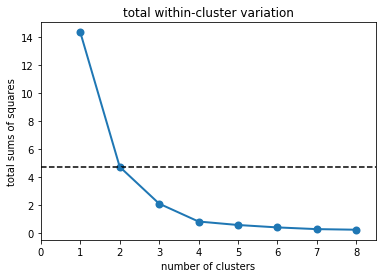

<Figure size 432x288 with 0 Axes>

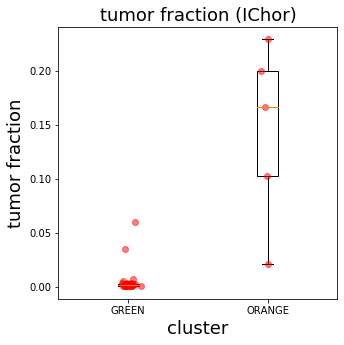

<Figure size 432x288 with 0 Axes>

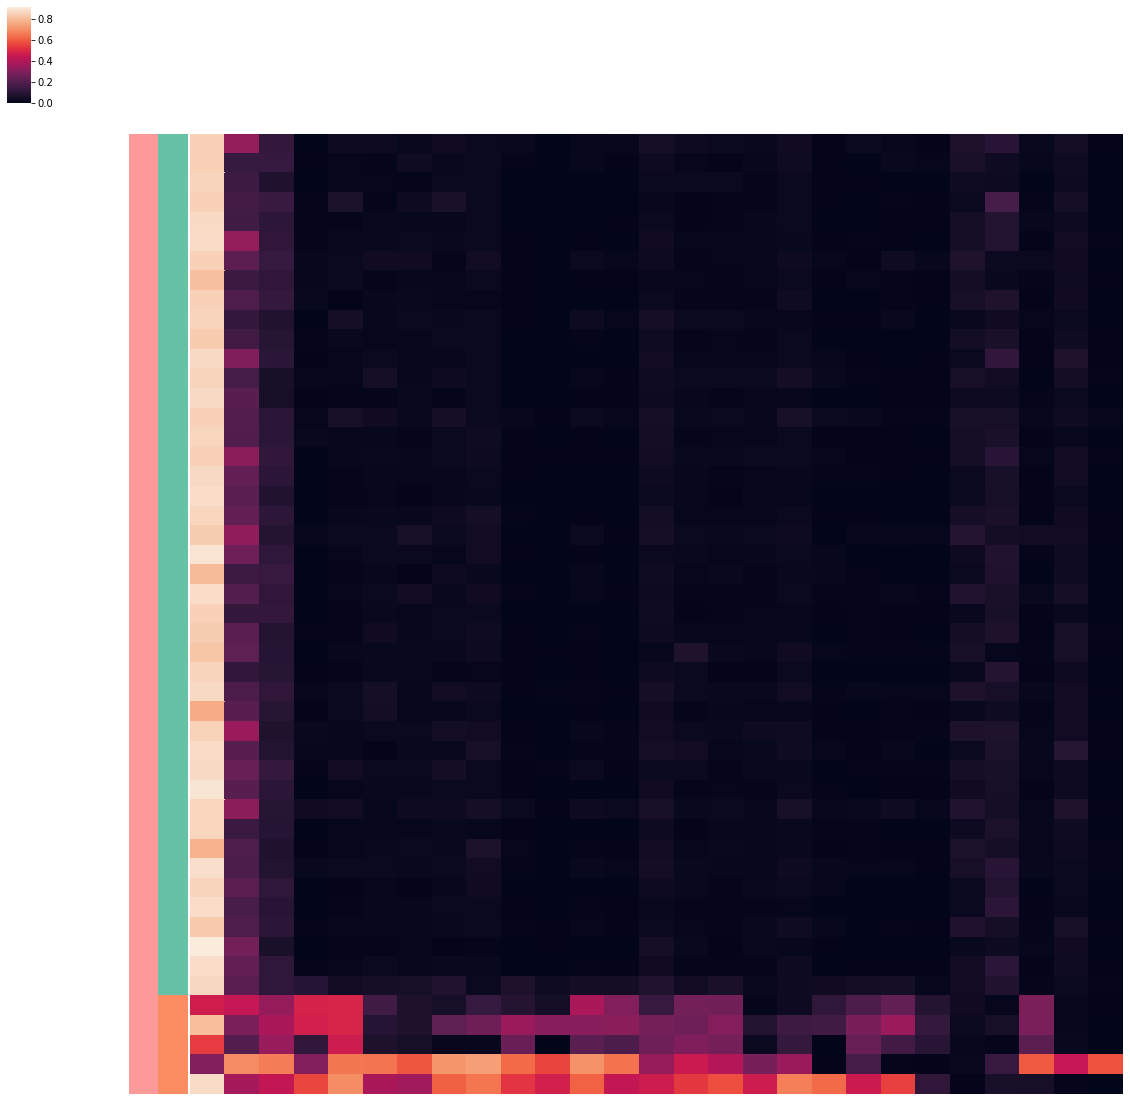

In [76]:
#cluster cfdna CRC samples only with cimpHL markers
samples = [lbl=="Cancer" for lbl in labels]
labels_sub = np.array([num_to_lab[l] for l in mat.get_labels()])[samples]
sample_metadata_sub = mat.get_metadata()[samples]
test_opt_num_clust_kmeans2(region_pct_meth_crc.loc[:,cimpHL_reg_bool], labels_sub, sample_metadata_sub, fig_pfx="cfDNA_kmeans_cimpHL_reg")

In [ ]:
# boxplot of tumor fraction by cluster membership




In [64]:
# CIMP tumors tend to have a high tumor fraction?
# High TF samples are the only ones where we can detect methylation at CIMP markers? If we turned up the gain on this heatmap, the 'cimp' cluster assignments might be totally different
# we would be getting some valuable data on the low TF samples. So we might not expect the CIMP clustering to show up on a heatmap or be detectable using hierarchical clustering on this data, the TF is just too low on most of the samples. 

# what if we further subset these regions to the 1-5 most highly methylated cimp regions? Of clustering that does not correspond with TF?
# are those top regions correspond to the top predictors from the Hinoue paper?

{'secondary_id': '102101-post', 'sample_dataset_id': 'SD-0000493A', 'sample_id': 13034, 'study_type': 'Prospective Clinical Study', 'collection_date': '2018-03-01', 'patient_id': 17524, 'diagnosis': None, 'raw_data_path': 'gs://seq-data-us-1/bam/190719_A00225_0334_BHJWGKDSXX/429e0d1f-0a59-549b-905f-d887953f4486/S_76_I_76-76_ACCATAGG-ACCATAGG_S76.marked.bam', 'assay': 'WGBS', 'analyte': 'cfDNA', 'assay_version': 2, 'cancer_type': 'Colorectal Cancer', 'lesion_location': 'Ascending colon (right)', 'lesion_location_collapsed': 'Proximal', 'tumor_size_mm': 60.0, 'num_adenomas': None, 'pathologic_type': None, 'pathologic_sub_type': None, 'full_stage': {'tnm_n': 'N1', 'tnm_t': 'T3', 'id': 11992, 'diagnosis_id': 12310, 'tnm_g': '2', 'tnm_n_suffix': 'b', 'tnm_m': 'M0'}, 'stage': 3, 'stage_conservative': 'stage_None', 'class_stage': 'stage_3', 'bam_id': '190719_A00225_0334_BHJWGKDSXX_S_76_I_76-76_ACCATAGG-ACCATAGG_S76', 'flowcells': 'A00225_BHJWGKDSXX', 'scrubbed_flowcells': 'HJWGKDSXX', 'merge_

In [ ]:
# sort markers by median methylation
samples = [lbl=="Cancer" for lbl in labels]
mat_crc = pd.DataFrame(region_pct_meth[samples])
medians = mat_crc.apply(np.median, axis=0)
mat_crc_sorted = mat_crc.reindex(medians.sort_values(ascending=False).index, axis=1)
#print(mat_crc_sorted.head())

n_clusters = [2,3,4,5,6]
for n in n_clusters:
    scores = []
    for n_markers in range(2,20):
        data = mat_crc_sorted.iloc[:,0:n_markers]
        clust = AgglomerativeClustering(n_clusters=n, linkage="ward")
        clust.fit(data)
        score = np.mean(metrics.silhouette_score(data, clust.labels_))
        scores.append(score)
        #print(f"markers {n_markers} : {round(score, 3)}")

    plt.figure()
    plt.scatter(range(2,20), scores, lw=2)
    plt.title(f"scores for clustering at k = {n}")
    plt.plot(range(2,20), scores, lw=2)
    plt.xlabel("number of markers")
    plt.ylabel(f"score for k={n}")
    #if fig_pfx:
    #    plt.savefig(f"./{fig_pfx}_scores.png")

# looks like clustering at k=2 using only the top 2-10 markers does not achieve a higher score than clustering at k=2 with all CIMP markers.

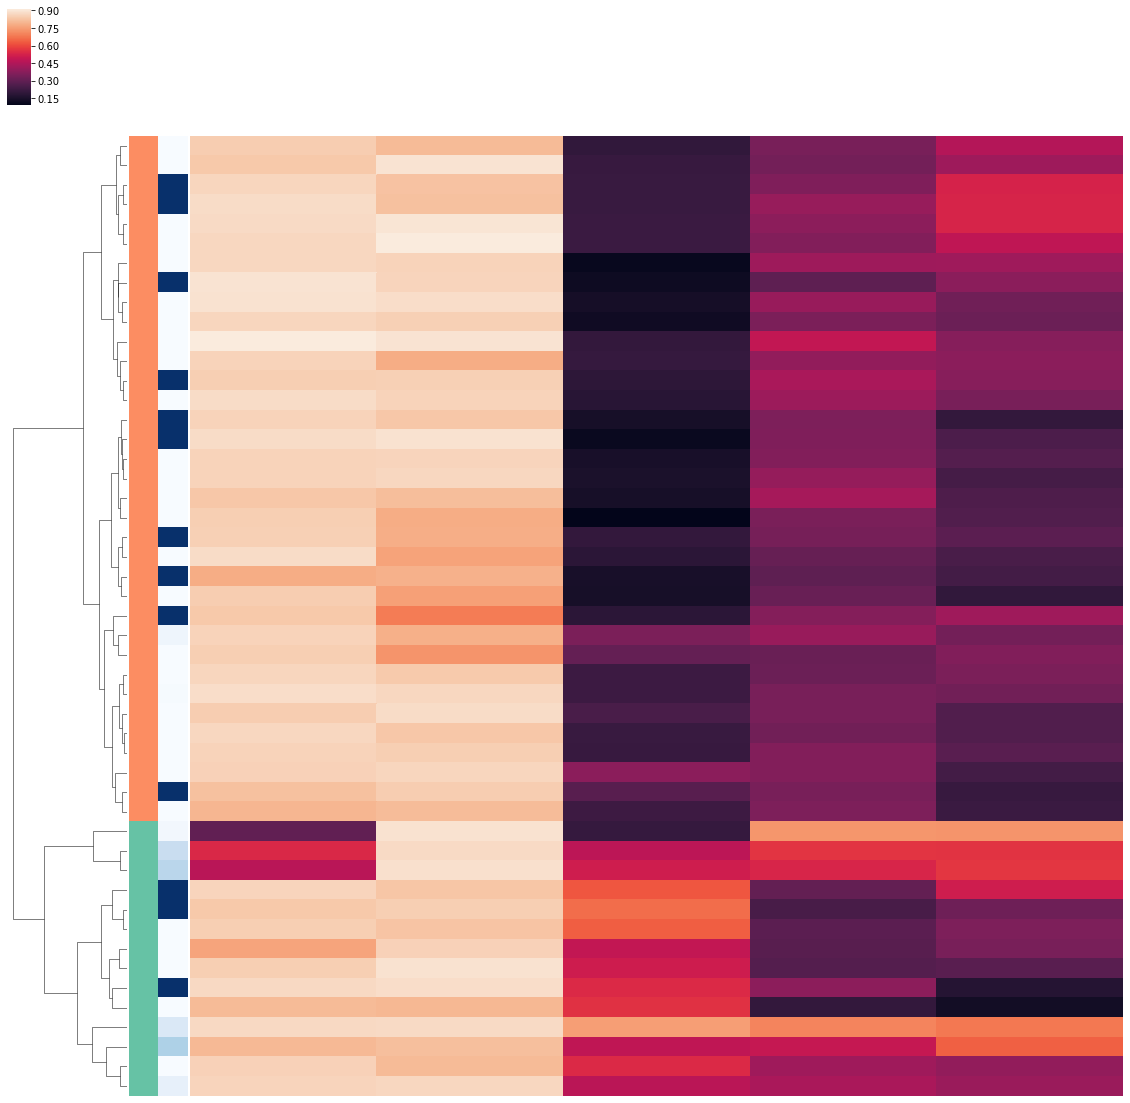

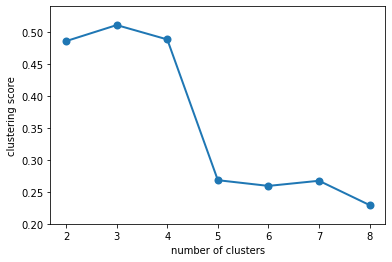

In [141]:
# plot heatmap using N top markers
N = 5

mat_n_markers = mat_crc_sorted.iloc[:,0:N]
# color rows by ichor tumor fraction (missing 8 crc samples)
cmap = plt.cm.Blues
sids = [d["sample_id"] for d in sample_metadata_sub] 
tfs_sub = []
for sid in sids:
    if sid in tf_dict.keys():
        tfs_sub.append(tf_dict[sid])
    else:
        tfs_sub.append(0.7) # this will map missing TF samples as color "black" I think
norm = matplotlib.colors.Normalize(vmin=min(tfs_sub), vmax=max(tfs_sub), clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
tumor_fraction_colors = mapper.to_rgba(tfs_sub)

# color samples by cluster membership at k = k
cols = sns.color_palette("Set2")
#d_row_colors = {}
#row_colors = [d_row_colors[lab] for lab in labels]
clust = AgglomerativeClustering(n_clusters=2, linkage="ward")
clust.fit(mat_n_markers)
clust_colors = [cols[c] for c in clust.labels_]

cg = sns.clustermap(mat_n_markers, figsize=(20,20), 
                    row_colors=[clust_colors, tumor_fraction_colors], 
                    xticklabels=[], 
                    yticklabels=[], method="ward")
cg.ax_col_dendrogram.set_visible(False) # remove col dendrogram

plt.savefig(f"./top_{N}_cimp_markers_heatmap.png")

# cluster scores
k_vals = [2,3,4,5,6,7,8]
    #k_vals = [2,3]
scores = []
#clust_lab_sets = []
for k in k_vals:
    clust = AgglomerativeClustering(n_clusters=k, linkage="ward")
    clust.fit(mat_n_markers)
    #score = metrics.calinski_harabasz_score(mat, clust.labels_)
    score = np.mean(metrics.silhouette_score(mat_n_markers, clust.labels_))
    scores.append(score)
    #clust_lab_sets.append(clust.labels_)
    #print(f"groups {k} : {round(score, 3)}")

plt.figure()
plt.scatter(k_vals, scores, lw=2)
plt.plot(k_vals, scores, lw=2)
plt.xlabel("number of clusters")
plt.ylabel("clustering score")

plt.savefig(f"./top_{N}_cimp_markers_clust_scores.png")